# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [16]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,647879,34.7,1321405,70.6,1321405,70.6
Vcells,1158743,8.9,8388608,64.0,1686097,12.9


Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [17]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

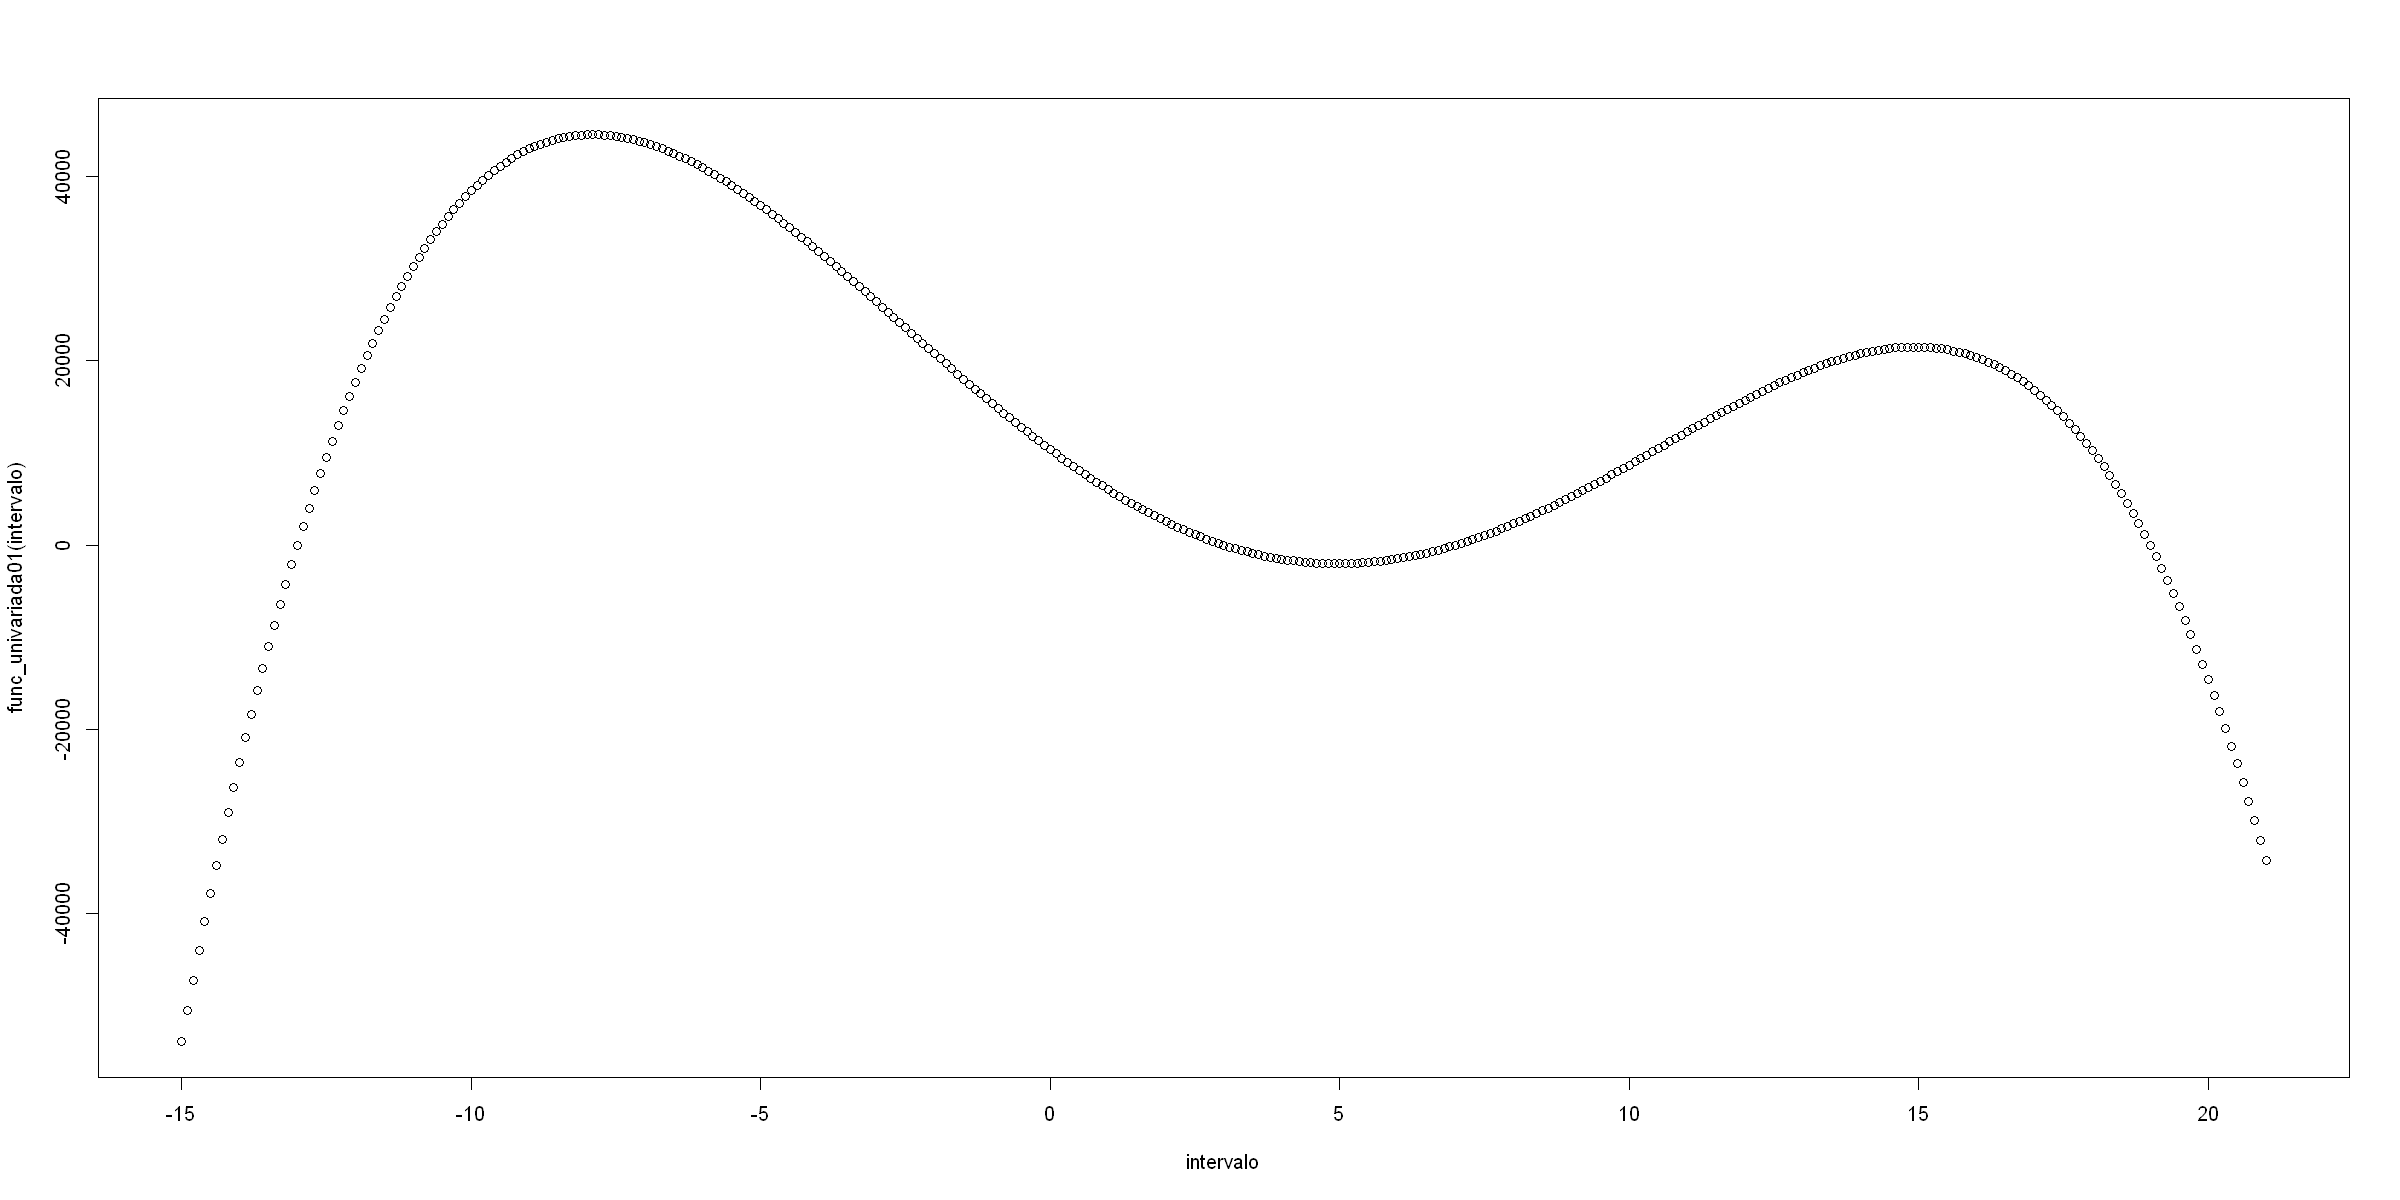

In [18]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [19]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01 ,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [20]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [21]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [22]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=-13.3 : y = -5.69e+03 : 0.2 secs : initdesign

[mbo] 0: x=60.9 : y = -1.93e+07 : 0.0 secs : initdesign

[mbo] 0: x=6.71 : y = -515 : 0.0 secs : initdesign

[mbo] 0: x=-74.1 : y = -7.1e+07 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -73.88979 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        73.89  |proj g|=    0.0012177
At iterate     1  f =        73.89  |proj g|=     0.0012167
At iterate     2  f =       73.889  |proj g|=    5.4627e-05
At iterate     3  f =       73.889  |proj g|=    2.6225e-06
At iterate     4  f =       73.889  |proj g|=    6.0833e-09

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 6.08332e-09
final function value 73.8888

F = 73.8888
final  value 73.888828 
converg

[mbo] 1: x=-3.75 : y = 3.06e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -90.1061 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       90.106  |proj g|=   0.00036384
At iterate     1  f =       90.106  |proj g|=    0.00036371

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000363713
final function value 90.1061

F = 90.1061
final  value 90.106105 
converged


[mbo] 2: x=24.6 : y = -1.62e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -106.9558 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       106.96  |proj g|=   0.00024814
At iterate     1  f =       106.96  |proj g|=    0.00024808

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000248084
final function value 106.956

F = 106.956
final  value 106.955785 
converged


[mbo] 3: x=16.5 : y = 1.89e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -122.1592 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       122.16  |proj g|=   0.00017461
At iterate     1  f =       122.16  |proj g|=    0.00017459

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000174588
final function value 122.159

F = 122.159
final  value 122.159200 
converged


[mbo] 4: x=-9.15 : y = 4.25e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -136.4197 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       136.42  |proj g|=   0.00021594
At iterate     1  f =       136.42  |proj g|=    0.00021592

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000215917
final function value 136.42

F = 136.42
final  value 136.419682 
converged


[mbo] 5: x=1.51 : y = 4.16e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -150.3928 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       150.39  |proj g|=   4.7304e-06
At iterate     1  f =       150.39  |proj g|=    4.7301e-06

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.73006e-06
final function value 150.393

F = 150.393
final  value 150.392811 
converged


[mbo] 6: x=20.5 : y = -2.45e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -164.102 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        164.1  |proj g|=    0.0016113
At iterate     1  f =        164.1  |proj g|=     0.0016112
At iterate     2  f =       164.08  |proj g|=     0.0002884
At iterate     3  f =       164.08  |proj g|=    6.3617e-05
At iterate     4  f =       164.08  |proj g|=    3.3909e-06
At iterate     5  f =       164.08  |proj g|=    4.2673e-08

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.2673e-08
final function 

[mbo] 7: x=11.7 : y = 1.47e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -177.6956 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        177.7  |proj g|=   0.00034743
At iterate     1  f =        177.7  |proj g|=    0.00034742

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.00034742
final function value 177.696

F = 177.696
final  value 177.695564 
converged


[mbo] 8: x=-11.3 : y = 2.71e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -190.3054 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       190.31  |proj g|=   1.4031e-07
At iterate     1  f =       190.31  |proj g|=     1.403e-07

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.40301e-07
final function value 190.305

F = 190.305
final  value 190.305412 
converged


[mbo] 9: x=-6.45 : y = 4.24e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -202.9436 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       202.94  |proj g|=   0.00086465
At iterate     1  f =       202.94  |proj g|=    0.00086461
At iterate     2  f =       202.94  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 202.937

F = 202.937
final  value 202.936644 
converged


[mbo] 10: x=-1.19 : y = 1.64e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -215.5165 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       215.52  |proj g|=    0.0015843
At iterate     1  f =       215.52  |proj g|=     0.0015843
At iterate     2  f =       215.51  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 215.507

F = 215.507
final  value 215.507061 
converged


[mbo] 11: x=14.1 : y = 2.1e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -227.9838 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       227.98  |proj g|=    0.0026798
At iterate     1  f =       227.98  |proj g|=     0.0026797
At iterate     2  f =       227.96  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 227.956

F = 227.956
final  value 227.955862 
converged


[mbo] 12: x=9.21 : y = 5.98e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -240.545 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       240.54  |proj g|=    0.0056149
At iterate     1  f =       240.54  |proj g|=     0.0056144
At iterate     2  f =       240.38  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 240.376

F = 240.376
final  value 240.376044 
converged


[mbo] 13: x=4.09 : y = -1.61e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -252.8072 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       252.81  |proj g|=    0.0041913
At iterate     1  f =       252.81  |proj g|=     0.0041911
At iterate     2  f =       252.78  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 252.777

F = 252.777
final  value 252.776929 
converged


[mbo] 14: x=-7.81 : y = 4.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -264.2715 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       264.27  |proj g|=     0.004732
At iterate     1  f =       264.27  |proj g|=     0.0047317
At iterate     2  f =       264.26  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 264.258

F = 264.258
final  value 264.258368 
converged


[mbo] 15: x=-5.17 : y = 3.76e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -275.7049 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        275.7  |proj g|=    0.0058804
At iterate     1  f =        275.7  |proj g|=       0.00588
At iterate     2  f =       275.66  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 275.664

F = 275.664
final  value 275.663534 
converged


[mbo] 16: x=18.3 : y = 7.42e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -287.8091 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       287.81  |proj g|=    0.0079156
At iterate     1  f =       287.81  |proj g|=     0.0079148
At iterate     2  f =       287.66  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 287.662

F = 287.662
final  value 287.662474 
converged


[mbo] 17: x=-10.1 : y = 3.8e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -299.3145 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       299.31  |proj g|=     0.014686
At iterate     1  f =       299.31  |proj g|=      0.014683
At iterate     2  f =       298.67  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 298.671

F = 298.671
final  value 298.670536 
converged


[mbo] 18: x=-2.54 : y = 2.38e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -309.9359 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       309.94  |proj g|=    0.0077817
At iterate     1  f =       309.94  |proj g|=     0.0077811
At iterate     2  f =       309.94  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 309.936

F = 309.936
final  value 309.935508 
converged


[mbo] 19: x=-7.17 : y = 4.4e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -320.2766 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       320.28  |proj g|=    0.0086593
At iterate     1  f =       320.28  |proj g|=     0.0086585
At iterate     2  f =       320.27  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 320.27

F = 320.27
final  value 320.269505 
converged


[mbo] 20: x=-8.46 : y = 4.42e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -330.6337 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       330.63  |proj g|=     0.010952
At iterate     1  f =       330.63  |proj g|=       0.01095
At iterate     2  f =       330.48  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 330.484

F = 330.484
final  value 330.484220 
converged


[mbo] 21: x=15.3 : y = 2.14e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -341.687 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       341.69  |proj g|=     0.011008
At iterate     1  f =       341.69  |proj g|=      0.011007
At iterate     2  f =       341.61  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 341.607

F = 341.607
final  value 341.607001 
converged


[mbo] 22: x=-5.85 : y = 4.04e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -351.8921 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       351.89  |proj g|=     0.012416
At iterate     1  f =       351.89  |proj g|=      0.012414
At iterate     2  f =       351.75  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 351.751

F = 351.751
final  value 351.750974 
converged


[mbo] 23: x=12.9 : y = 1.85e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -362.8986 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        362.9  |proj g|=     0.012519
At iterate     1  f =        362.9  |proj g|=      0.012518
At iterate     2  f =       362.83  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 362.826

F = 362.826
final  value 362.826003 
converged


[mbo] 24: x=-12.2 : y = 1.4e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -373.926 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       373.93  |proj g|=     0.013687
At iterate     1  f =       373.93  |proj g|=      0.013685
At iterate     2  f =       373.81  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 373.811

F = 373.811
final  value 373.811332 
converged


[mbo] 25: x=0.122 : y = 9.81e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  269.8431 
  - best initial criterion value(s) :  -385.0468 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       385.05  |proj g|=     0.013767
At iterate     1  f =       385.05  |proj g|=      0.013765
At iterate     2  f =       385.01  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 385.006

F = 385.006
final  value 385.006499 
converged


In [23]:
tb_resultados  <- as.data.table( run$opt.path )

In [24]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-13.2675349,-5.692446e+03,0,NA,NA,0.2,NA,NA,NA,initdesign,NA,NA,NA
60.8625839,-1.927372e+07,0,NA,NA,0.0,NA,NA,NA,initdesign,NA,NA,NA
6.7137710,-5.149287e+02,0,NA,NA,0.0,NA,NA,NA,initdesign,NA,NA,NA
-74.0589631,-7.098422e+07,0,NA,NA,0.0,NA,NA,NA,initdesign,NA,NA,NA
-3.7521577,3.055141e+04,1,NA,NA,0.0,-3395617.875,NA,0.30,infill_ei,1.03,5455051.49,2114971.239
24.6358746,-1.618694e+05,2,NA,NA,0.0,-1529130.860,NA,0.05,infill_ei,0.50,8109871.21,-4271660.926
16.5060678,1.889539e+04,3,NA,NA,0.0,-930166.023,NA,0.09,infill_ei,1.08,1711483.83,478756.349
-9.1531896,4.252134e+04,4,NA,NA,0.0,-413861.644,NA,0.17,infill_ei,1.16,596050.13,325593.354
1.5072475,4.161511e+03,5,NA,NA,0.0,-190756.787,NA,0.13,infill_ei,1.34,495486.94,28536.068


In [25]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.809936,44552.78,14,NA,NA,0,-17309.37,NA,0.06,infill_ei,0.72,39199.83,45756.68


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?